##Neste notebook será feita a estimação de parâmetros para o sistema Metanol-Água no modelo de Wilson. Essa estimação será feita minimizando os desvios dos resultados de temperatura do ponto de bolha e composição da fase gasosa calculados pelo modelo de Wilson e aqueles de dados experimentais obtidos pelo Dortmund Data Bank, dados esses disponíveis em:

###http://www.ddbst.com/en/EED/VLE/VLE%20Methanol%3BWater.php

##Aqui vou usar o Data set 466.

#Nesta versão, a estimação dos parâmetros de Wilson será feita considerando o cálculo do $Φ$ por meio das equações de estado (EOS) e não pelo $\Phi$ genérico

In [ ]:
# Preparando kernel
import numpy as np
import pandas as pd
!pip3 install pickle5
import pickle5 as pickl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=256408 sha256=6b7157f6a8e5779228f37458893372c3715558378a50fbf1b688ea32d6028612
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


In [ ]:
# Montando o Google drive
from google.colab import drive
drive.mount('/content/drive')
# Para ler/carregar
#path = '/content/drive/MyDrive/Operações 3/'
path = '/content/drive/MyDrive/PFG_Mateus_Ferreira/'
#path = '/content/drive/MyDrive/Classroom/OpUnit3_files/OU3_Python/'
with open(path + 'databank_properties.pickle', 'rb') as handle:
    dados, all_units = pickl.load(handle)
print(dados.shape)
# Incluindo uma pasta do drive (mounted) no path do COLAB
import sys
sys.path.append(path)
# Carregamento das funções úteis
from OU3_funcoes_uteis_v05_2 import *
import TEQ_funcoes_uteis_v06 as teq
import OU3_funcoes_uteis_v05_2 as ou3

Mounted at /content/drive
(468, 31)


In [ ]:
# Para procurar o 'num' de um determinado componente pelo nome
dados[dados.name.str.contains('water', case = False)]

,num,name,molar_mass,fusion_point,boiling_point,critical_temp,critical_pressure,critical_volume,zc,acentric_factor,...,pvap_a,pvap_b,pvap_c,temp_max_pvap,temp_min_pvap,pvap_h_a,pvap_h_b,pvap_h_c,pvap_h_d,delta_h_vap_bp
466,20,WATER,18.015,273.2,373.2,647.3,217.6,56.0,0.229,0.344,...,18.3036,3816.44,-46.13,441.0,284.0,55.336,-6869.5,-5.115,1.05,9717.0


In [ ]:
# Seleção dos componentes presentes no sistema
lista_componentes = [62, 20]
nc = len(lista_componentes)
nc

2

In [ ]:
dados[dados['num'].isin(lista_componentes)][['num','name']]

,num,name
296,62,METHANOL
466,20,WATER


In [ ]:
# Verificando os pontos de ebulição de nossos componentes
T_eb_comp = dados[dados['num'].isin(lista_componentes)]['boiling_point']
T_eb_comp = T_eb_comp.tolist()
T_eb_comp

[337.8, 373.2]

In [ ]:
# Valores do a_W - Tabela 12.5, p. 354 SVNA
# metanol = 1
# água = 2
nc = 2
a_W = np.zeros((nc,nc))
# acetona e metanol

a_W[0][1] = 107.38
a_W[1][0] = 469.55

a_W

array([[  0.  , 107.38],
       [469.55,   0.  ]])

In [ ]:
#Cálculando o volume molar
V_m = f_Vol_molar_db(lista_componentes, dados)
V_m

array([40.50821745, 18.0511022 ])

In [ ]:
#Pressão de equilíbrio usada nos dados do Dortmund:
P_eq = 97.99*(760.00/101.325) #mmHg
P_eq

734.9854428818159

In [ ]:
#Definindo a função que calcula a temperatura do ponto de bolha usando o PHI GENÉRICO
#
def f_calc_T_Pb_nid_Wilson_01_db(z, P_eq, a_W, V_m, lista_componentes, dados):
  ''' Algoritmo de BOL_T descrito na figura 14.3 p.409 do SVNA
  '''
  nc = z.shape[0]
  resp = f_calculo_PbPo_db('T', P_eq, z, lista_componentes, dados)
  T_pb_ideal = resp[0]
  T_pb = T_pb_ideal
  x_eq = z
  y_eq = f_sol_RR_flash_db(z, P_eq, T_pb, lista_componentes, dados)['y_eq']
  K_comp = f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq, x_eq, y_eq, a_W, V_m, 
                                       lista_componentes, dados)
  # Eq.14.8 do SVNA
  y_eq_novo = K_comp * x_eq
  phi_comp = f_phi_gen(y_eq_novo, T_pb, P_eq)
  gama_comp = f_gama_Wilson(x_eq, T_pb, a_W, V_m)
  # Componente de referência
  jj = 1                                               #Aqui mudei o jj de 2 para 1 porque estava dando erro de índice
  # Eq. 14.13 do SVNA
  fator = x_eq*gama_comp/phi_comp
  Pvap_comp = f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, dados)
  razao = Pvap_comp/Pvap_comp[jj]
  somat = fator @ razao
  Pvap_novo = P_eq / somat
  # Eq. 14.15 do SVNA
  T_pb_novo = f_Teq_Antoine_db(Pvap_novo, lista_componentes[jj], dados)[0]
  erro_T = T_pb_novo - T_pb
  # Tolerância para convergência
  epsilon = 1.0e-3
  #
  T_pb = T_pb_novo
  y_eq = y_eq_novo
  k_iter = 1
  n_max_iter = 20
  while ((np.abs(erro_T).mean() > epsilon)&(k_iter < n_max_iter)):
    print(k_iter, np.abs(erro_T).mean())
    K_comp = f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq, x_eq, y_eq, 
                                       a_W, V_m, lista_componentes, dados)
    y_eq_novo = K_comp * x_eq
    phi_comp = f_phi_gen(y_eq_novo, T_pb, P_eq)
    gama_comp = f_gama_Wilson(x_eq, T_pb, a_W, V_m)
    fator = x_eq*gama_comp/phi_comp
    Pvap_comp = f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, dados)
    T_pb_novo = np.zeros((nc,))
    for j in range(0, nc):
      razao = Pvap_comp/Pvap_comp[j]
      somat = fator @ razao
      Pvap_novo = P_eq / somat
      T_pb_novo[j] = f_Teq_Antoine_db(Pvap_novo, lista_componentes[j], dados)[0]
    erro_T = T_pb_novo[jj] - T_pb
    T_pb = T_pb_novo[jj] # T_pb_novo.mean()
    y_eq = y_eq_novo
    k_iter += 1
  #
  return {'T_pb': T_pb, 'y_eq':y_eq, 'erro_T': np.abs(erro_T)}

##**Inserindo as funções necessárias para se calcular o BOL_T por Wilson usando $\Phi$ das equações de estado (EOS): Van der Waals, RK, SRK e Peng - Robinson.**

In [ ]:
def f_K_Wilson_phi_EOS(x, y, T, P, a_W, V_m, i_EOS, lista_componentes, dados):
  nc = x.shape[0]
  # Função para o cálculo do phi
  phi_comp  = f_phi_ELV_EOS(T, P, y, i_EOS, lista_componentes, dados)['phi']
  # Para o cálculo do gama
  gama_comp = f_gama_Wilson(x, T, a_W, V_m)
  # Cálculo de P_vap
  Pvap_comp = f_Pvap_Antoine_vetor_db(T, lista_componentes, dados)
  Pvap_comp_bar = Pvap_comp *(1.0133/760.0)
  # Cálculo do K
  K = np.zeros((nc,))
  for i in range(0,nc):
    K[i] = (Pvap_comp_bar[i]*gama_comp[i])/(P*phi_comp[i])
  #
  return K

In [ ]:
def f_fator_Poynting(T, P, lista_componentes, dados):
  ''' Calcula o fator de correção de Poynting segundo a Eq. 11.44 p.297
  '''
  nc = len(lista_componentes)
  R_ig = 83.14 # bar*cm3/mol/K
  V_m = f_Vol_molar_db(lista_componentes, dados)
  Pvap_comp = f_Pvap_Antoine_vetor_db(T, lista_componentes, dados)*(1.01325/760.0)
  fatPoy = np.zeros((nc,))
  for i in range(0,nc):
    num       = V_m[i]*(P - Pvap_comp[i])
    den       = R_ig*T
    fatPoy[i] = np.exp(-num/den)
  return fatPoy

In [ ]:
def f_phi_ELV_EOS(T, P, y, i_EOS, lista_componentes, dados):
    #nc   = y.shape[0]
    R_ig = 83.14 # bar*cm3/mol/K
    # Obtendo: Tc, Pc_ omega
    Tc_comp = dados[dados['num'].isin(lista_componentes)]['critical_temp'].to_numpy()
    Pc_comp = dados[dados['num'].isin(lista_componentes)]['critical_pressure'].to_numpy()*(1.0133/1.0)
    om_comp = dados[dados['num'].isin(lista_componentes)]['acentric_factor'].to_numpy()
    #
    resp_EOS     = teq.f_calc_param_EOS_mistura(i_EOS, y, T, P, Tc_comp, 
                                                Pc_comp, om_comp, R_ig)
    param_EOS    = resp_EOS['param_EOS']
    param_cubica = teq.f_conv_param(param_EOS)
    Z_all        = teq.f_raizes_cubica(param_cubica)['x']
    Z_v          = np.max(Z_all)
    a_EOS        = resp_EOS['a_comp']
    b_EOS        = resp_EOS['b_comp']
    phi_chapeu   = teq.f_phi_chapeu_EOS_eq_14_50(Z_v, T, P, R_ig, a_EOS, 
                                                 b_EOS, y, param_EOS)
    #
    phi_sat      = teq.f_phi_sat_comp(T, i_EOS, lista_componentes, dados)
    #
    fatPoy = f_fator_Poynting(T, P, lista_componentes, dados)
    #
    phi = (phi_chapeu/phi_sat)*fatPoy
    return {'phi': phi, 'phi_chapeu': phi_chapeu, 'phi_sat': phi_sat,
            'fatPoy': fatPoy }

In [ ]:
def f_K_Wilson_phi_EOS(x, y, T, P, a_W, V_m, i_EOS, lista_componentes, dados):
  nc = x.shape[0]
  # Função para o cálculo do phi
  phi_comp  = f_phi_ELV_EOS(T, P, y, i_EOS, lista_componentes, dados)['phi']
  # Para o cálculo do gama
  gama_comp = ou3.f_gama_Wilson(x, T, a_W, V_m)
  # Cálculo de P_vap
  Pvap_comp = ou3.f_Pvap_Antoine_vetor_db(T, lista_componentes, dados)
  Pvap_comp_bar = Pvap_comp *(1.0133/760.0)
  # Cálculo do K
  K = np.zeros((nc,))
  for i in range(0,nc):
    K[i] = (Pvap_comp_bar[i]*gama_comp[i])/(P*phi_comp[i])
  #
  return K

In [ ]:
def f_calc_T_Pb_nid_Wilson_EOS_db(z, P_eq, a_W, V_m, i_EOS, lista_componentes, dados):
  ''' Algoritmo de BOL_T descrito na figura 14.3 p.409 do SVNA
      K calculado utilizando a abordagem gamma/phi com:
      gamma: modelo de Wilson
      phi:   calculado com as equações do capítulo 14 usando a razão
             phi_chapeu/phi_sat
  '''
  nc = z.shape[0]
  # Cálculo do ELV usando Raoult - sistema ideal
  P_eq_mmHg = P_eq*(760.0/1.01325)
  resp = ou3.f_calculo_PbPo_db('T', P_eq_mmHg, z, lista_componentes, dados)
  T_pb_ideal = resp[0]
  T_pb = T_pb_ideal
  x_eq = z
  y_eq = ou3.f_sol_RR_flash_db(z, P_eq_mmHg, T_pb, lista_componentes, dados)['y_eq']
  # K_comp = ou3.f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq_mmHg, x_eq, y_eq, a_W, V_m, 
  #                                      lista_componentes, dados)
  K_comp = f_K_Wilson_phi_EOS(x_eq, y_eq, T_pb, P_eq, a_W, V_m, i_EOS, 
                              lista_componentes, dados)
  # Eq.14.8 do SVNA
  y_eq_novo = K_comp * x_eq
  #phi_comp = ou3.f_phi_gen(y_eq_novo, T_pb, P_eq_mmHg)
  phi_comp = f_phi_ELV_EOS(T_pb, P_eq, y_eq_novo, i_EOS, 
                           lista_componentes, dados)['phi']
  gama_comp = ou3.f_gama_Wilson(x_eq, T_pb, a_W, V_m)
  # Componente de referência
  jj = nc - 1
  # Eq. 14.13 do SVNA
  fator = x_eq*gama_comp/phi_comp
  Pvap_comp = ou3.f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, dados)*(1.01325/760.0)
  razao = Pvap_comp/Pvap_comp[jj]
  somat = fator @ razao
  Pvap_novo = P_eq / somat
  # Eq. 14.15 do SVNA
  T_pb_novo = ou3.f_Teq_Antoine_db(Pvap_novo*(760.0/1.01325), 
                                   lista_componentes[jj], dados)[0]
  erro_T = T_pb_novo - T_pb
  # Tolerância para convergência
  epsilon = 1.0e-3
  #
  T_pb = T_pb_novo
  y_eq = y_eq_novo
  k_iter = 1
  n_max_iter = 20
  while ((np.abs(erro_T).mean() > epsilon)&(k_iter < n_max_iter)):
    print(k_iter, np.abs(erro_T).mean())
    # K_comp = ou3.f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq_mmHg, x_eq, y_eq, 
    #                                    a_W, V_m, lista_componentes, dados)
    K_comp = f_K_Wilson_phi_EOS(x_eq, y_eq, T_pb, P_eq, a_W, V_m, i_EOS, 
                              lista_componentes, dados)
    y_eq_novo = K_comp * x_eq
    #phi_comp  = ou3.f_phi_gen(y_eq_novo, T_pb, P_eq_mmHg)
    phi_comp = f_phi_ELV_EOS(T_pb, P_eq, y_eq_novo, i_EOS, 
                             lista_componentes, dados)['phi']
    gama_comp = ou3.f_gama_Wilson(x_eq, T_pb, a_W, V_m)
    fator     = x_eq*gama_comp/phi_comp
    Pvap_comp = ou3.f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, 
                                            dados)*(1.01325/760.0)
    T_pb_novo = np.zeros((nc,))
    #
    for j in range(0,nc):
      razao = Pvap_comp/Pvap_comp[j]
      somat = fator @ razao
      Pvap_novo = P_eq / somat
      T_pb_novo[j] = ou3.f_Teq_Antoine_db(Pvap_novo*(760.0/1.01325), 
                                          lista_componentes[j], dados)[0]
    erro_T = T_pb_novo[jj] - T_pb
    T_pb = T_pb_novo[jj] # T_pb_novo.mean()
    y_eq = y_eq_novo
    k_iter += 1
  #
  return {'T_pb': T_pb, 'y_eq':y_eq, 'erro_T': np.abs(erro_T)}

##**Fim das funções necessárias para o cáculo de BOL_T**

##Criando um Data frame para receber os dados do Data Set 466

In [ ]:
caminho = '/content/drive/MyDrive/PFG_Mateus_Ferreira/Dados_ELV_metanol_agua.xlsx'
df = pd.read_excel(caminho)
df.head()

,T [K],x1,y1
0,369.65,0.0084,0.103
1,365.45,0.0258,0.227
2,360.65,0.0680,0.391
3,353.25,0.1370,0.568
4,349.05,0.2400,0.680


In [ ]:
#adicionando duas colunas com os valores de x2 e y2
df['x2'] = 1 - df['x1']
df['y2'] = 1 - df['y1']
#Reordenando as colunas do Data Frame (apenas por fins estéticos)
df = df[['T [K]', 'x1', 'x2', 'y1', 'y2']]
#
#Visualizando os dados de validação
df

,T [K],x1,x2,y1,y2
0,369.65,0.0084,0.9916,0.103,0.897
1,365.45,0.0258,0.9742,0.227,0.773
2,360.65,0.0680,0.9320,0.391,0.609
3,353.25,0.1370,0.8630,0.568,0.432
4,349.05,0.2400,0.7600,0.680,0.320
5,343.75,0.4800,0.5200,0.790,0.210
6,341.85,0.5720,0.4280,0.820,0.180
7,339.55,0.7410,0.2590,0.906,0.094


In [ ]:
#Transformando os dados de entrada do que estão no Data Frame em uma lista de listas onde cada lista interna contém os valores de fração molar
# de cada componente

x1 = df['x1'].tolist()
x2 = df['x2'].tolist()
lista_composicoes = np.array(list(zip(x1, x2)))
lista_composicoes

array([[0.0084, 0.9916],
       [0.0258, 0.9742],
       [0.068 , 0.932 ],
       [0.137 , 0.863 ],
       [0.24  , 0.76  ],
       [0.48  , 0.52  ],
       [0.572 , 0.428 ],
       [0.741 , 0.259 ]])

In [ ]:
#Definindo os parâmetros para inserir na função do cálculo dos resíduos
par = np.array([-161.88, 583.11])
par

array([-161.88,  583.11])

#Cálculo dos resíduos de $T_{pb}$, $y_1$ e $y_2$ com os parâmetros do livro

In [ ]:
#Definindo um i_EOS (índice da equação de estado que será utilizada no cálculo do Phi):
i_EOS = 3 #(3 == SRK)

##**Muita atenção!** a função f_calc_T_Pb_nid_Wilson_EOS_db utiliza a pressão de equilíbrio em BAR e não em mmHg

In [ ]:
def f_res_par(par, P_eq_bar, V_m, lista_componentes, dados, df):
  '''
    Entradas:
      df: dataframe com os dados experimentais para a estimação
    Saidas:

  '''

  nc = 2
  a_W = np.zeros((nc, nc))
  #
  a_W[0][1] = par[0]
  a_W[1][0] = par[1]
  #
  composicoes = df[['x1', 'x2']]
  x1 = composicoes['x1'].tolist()
  x2 = composicoes['x2'].tolist()
  z = np.array(list(zip(x1, x2)))
  #
  n_exp = df.shape[0]
  res_T = np.zeros((n_exp,))
  res_y1 = np.zeros((n_exp,))
  res_y2 = np.zeros((n_exp,))
  for k in range(0, n_exp):
    print(k)
    #
    sol_T_pb = f_calc_T_Pb_nid_Wilson_EOS_db(z[k], P_eq_bar, a_W, V_m, i_EOS, lista_componentes, dados)   #usando Phi EOS - Pressão em BAR
    #sol_T_pb = f_calc_T_Pb_nid_Wilson_01_db(z[k], P_eq, a_W, V_m, lista_componentes, dados)              #usando Phi genérico - Pressão em mmHg
    res_T[k] = df.loc[k, 'T [K]'] - sol_T_pb['T_pb']
    res_y1[k] = df.loc[k,'y1'] - sol_T_pb['y_eq'][0]
    res_y2[k] = df.loc[k,'y2'] - sol_T_pb['y_eq'][1]
  #
  res = np.abs(res_T) + np.abs(res_y1) + np.abs(res_y2)
  return (res)

In [ ]:
#Definindo um pressão de quilíbrio em bar, convertendo a P_eq
P_eq_bar = P_eq*(1.01325/760) #bar
P_eq_bar

0.9798999999999999

In [ ]:
%%capture
res = f_res_par(par, P_eq_bar, V_m, lista_componentes, dados, df)

In [ ]:
res

array([ 2.34191877,  5.87838889,  8.83467869, 13.1564768 , 12.72782951,
        8.15863886,  6.78316344,  3.67143958])

In [ ]:
%%capture
from scipy.optimize import least_squares
# resp = least_squares(f_res_par, par, args=(P_eq, V_m, lista_componentes, dados, df))
resp = least_squares(f_res_par, par, method = 'lm',
                     args=(P_eq_bar, V_m, lista_componentes, dados, df))

In [ ]:
#Obtendo o resutado da otimização, ou seja, os parâmetros ótimos, dados por "x".
resp

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 4.547e-01  8.355e-01  9.343e-01  4.017e-01  2.247e-01
                2.555e-01  2.922e-01  3.759e-01]
           x: [ 1.273e+03 -3.971e+02]
        cost: 1.1406798756143095
         jac: [[-3.242e-03 -2.549e-03]
               [-7.825e-03 -6.563e-03]
               ...
               [-2.801e-03 -7.688e-03]
               [-1.591e-03 -4.649e-03]]
        grad: [ 1.475e-09 -9.198e-10]
  optimality: 1.4749362182986392e-09
 active_mask: [0 0]
        nfev: 24
        njev: None

In [ ]:
#parâmetros ótimos do sistema Metanol-Água:
par_opt = resp.x
par_opt

array([1272.61896714, -397.11108971])

##Agora tendo os parâmetros ótimos é só inserí-los na função do cálculo dos resíduos para ver se, de fato, os resíduos ficaram baixos.

In [ ]:
%%capture
res_opt = f_res_par(par_opt, P_eq_bar, V_m, lista_componentes, dados, df)

In [ ]:
res_opt

array([0.45471949, 0.83545038, 0.93427221, 0.40167013, 0.2246502 ,
       0.25545606, 0.29216284, 0.37593151])

In [ ]:
#Comparando com os resíduos anteriores:
res

array([ 2.34191877,  5.87838889,  8.83467869, 13.1564768 , 12.72782951,
        8.15863886,  6.78316344,  3.67143958])

##Como é possível observar, os resíduos diminuíram muito. Agora, realiza-se a simulação e análise gráfica dos dados experimentais ajustados aos novos parâmetros obtidos

In [ ]:
#Definindo uma função que lê listas de composições de calcula o ponto de bolha da mistur binária e a composição da fase gasosa resultante:
def calcular_ponto_bolha_2_componentes(composicoes, P_eq_bar, a_W, V_m, i_EOS, lista_componentes, dados):
    '''função que calcula a temperatura do ponto de bolha e a composição da fase vapor para uma mistura de componentes e
    armazena os valores em um Data Frame chamado df_resultados.
    z é a lista (ou lista de listas) da composição da fase líquida e P_eq é a pressão de equilíbrio do sistema'''
    resultados = []
    for composicao in composicoes:
        # Chame a função que realiza o cálculo da temperatura do ponto de bolha
        # e da composição da fase vapor com base na composição da mistura e na pressão do sistema
        T_pb_Wilson             = f_calc_T_Pb_nid_Wilson_EOS_db(composicao, P_eq_bar, a_W, V_m, i_EOS, lista_componentes, dados)['T_pb']
        y1_Wilson               = f_calc_T_Pb_nid_Wilson_EOS_db(composicao, P_eq_bar, a_W, V_m, i_EOS, lista_componentes, dados)['y_eq'][0]
        y2_Wilson               = f_calc_T_Pb_nid_Wilson_EOS_db(composicao, P_eq_bar, a_W, V_m, i_EOS, lista_componentes, dados)['y_eq'][1]
        
        # Adicione os resultados em uma lista como tuplas
        resultados.append((composicao, T_pb_Wilson, y1_Wilson, y2_Wilson))
    
    # Criando um DataFrame a partir da lista de resultados
    df_resultados = pd.DataFrame(resultados, columns=["Composição", "T_pb_Wilson", "y1_Wilson", "y2_Wilson"])
    
    return df_resultados

##Após definida a função, é necessário calcular um novo a_W com os parâmetros ótimos para assim testar a função que calcular o ponto de bolha e as composições usando o mesmo:

In [ ]:
#Definindo o a_W ótimo:
a_W_opt = np.zeros((nc,nc))
#
a_W_opt[0][1] = par_opt[0]
a_W_opt[1][0] = par_opt[1]

In [ ]:
#Criando um Data frame com o resultado da estimativa dos valores de y1, y2 e T_pb
%%capture
resultado = calcular_ponto_bolha_2_componentes(lista_composicoes, P_eq_bar, a_W_opt, V_m, i_EOS, lista_componentes, dados)

In [ ]:
resultado

,Composição,T_pb_Wilson,y1_Wilson,y2_Wilson
0,"[0.0084, 0.9916]",370.063320,0.082325,0.917725
1,"[0.0258, 0.9742]",366.260453,0.214539,0.785536
2,"[0.068, 0.9319999999999999]",359.750497,0.408418,0.591649
3,"[0.137, 0.863]",353.635081,0.559733,0.440322
4,"[0.24, 0.76]",348.858731,0.663337,0.336718
5,"[0.48, 0.52]",343.519258,0.777687,0.222401
6,"[0.572, 0.42800000000000005]",342.124906,0.811413,0.188670
7,"[0.741, 0.259]",339.864828,0.875484,0.124588


##Agora tendo os valores calculados por Wilson e aqueles experimentais presentes no conjunto de dados faz-se um comparativo entre ambos

#Fazendo uma análise gráfica dos resultados por uma reta de referência em relação a cada uma das variáveis de reposta: $T_{pb}$, $y_1$ e $y_2$


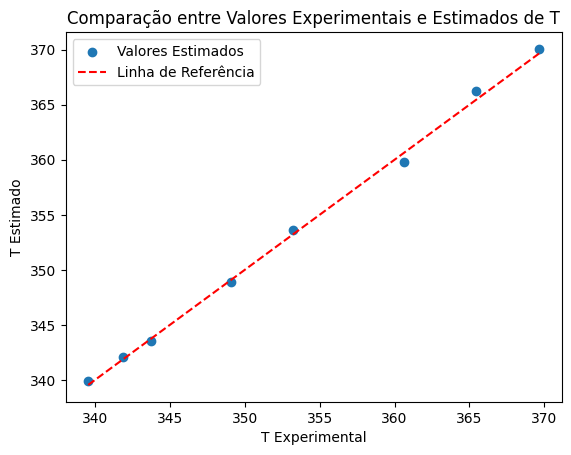

In [ ]:
import matplotlib.pyplot as plt

# Criando um gráfico de dispersão com linha de regressão para T

plt.scatter(df['T [K]'], resultado['T_pb_Wilson'], label='Valores Estimados')
plt.plot([df['T [K]'].min(), df['T [K]'].max()], [df['T [K]'].min(), df['T [K]'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('T Experimental')
plt.ylabel('T Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de T')
plt.legend()
plt.show()

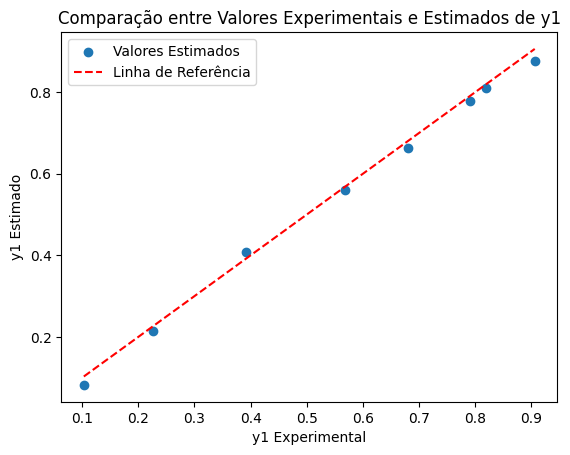

In [ ]:
# Criando um gráfico de dispersão com linha de regressão para y1

plt.scatter(df['y1'], resultado['y1_Wilson'], label='Valores Estimados')
plt.plot([df['y1'].min(), df['y1'].max()], [df['y1'].min(), df['y1'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('y1 Experimental')
plt.ylabel('y1 Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de y1')
plt.legend()
plt.show()

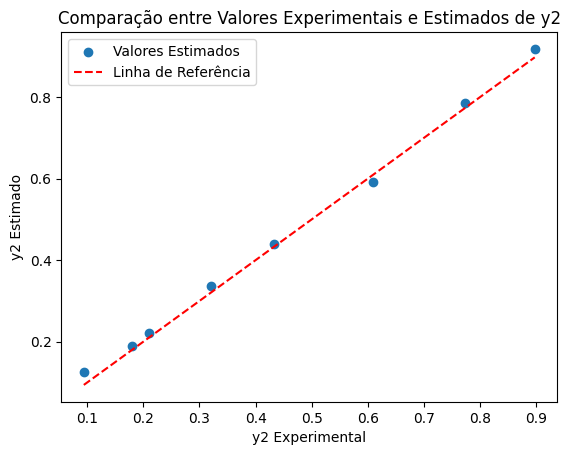

In [ ]:
# Criando um gráfico de dispersão com linha de regressão para y2

plt.scatter(df['y2'], resultado['y2_Wilson'], label='Valores Estimados')
plt.plot([df['y2'].min(), df['y2'].max()], [df['y2'].min(), df['y2'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('y2 Experimental')
plt.ylabel('y2 Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de y2')
plt.legend()
plt.show()

##Analisando os desvios e o $R^2$

In [ ]:
# Importando o pacote com as figuras de mérito para avaliar o modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Calculando o erro médio absoluto (MAE)
mae_T = mean_absolute_error(df['T [K]'], resultado['T_pb_Wilson'])
mae_y1 = mean_absolute_error(df['y1'], resultado['y1_Wilson'])
mae_y2 = mean_absolute_error(df['y2'], resultado['y2_Wilson'])

# Calculando o erro quadrático médio (MSE)
mse_T = mean_squared_error(df['T [K]'], resultado['T_pb_Wilson'])
mse_y1 = mean_squared_error(df['y1'], resultado['y1_Wilson'])
mse_y2 = mean_squared_error(df['y2'], resultado['y2_Wilson'])

# Calculando a raiz do erro quadrático médio (RMSE)
rmse_T  = np.sqrt(mse_T)
rmse_y1 = np.sqrt(mse_y1)
rmse_y2 = np.sqrt(mse_y2)

# Calculando o coeficiente de determinação (R²)
r2_T  = r2_score(df['T [K]'], resultado['T_pb_Wilson'])
r2_y1 = r2_score(df['y1'], resultado['y1_Wilson'])
r2_y2 = r2_score(df['y2'], resultado['y2_Wilson'])

In [ ]:
#Imprimindo os resultados:
print("Erro Médio Absoluto (MAE) para T: ", mae_T)
print("Erro Médio Absoluto (MAE) para y1: ", mae_y1)
print("Erro Médio Absoluto (MAE) para y2: ", mae_y2)

print("Erro Quadrático Médio (MSE) para T: ", mse_T)
print("Erro Quadrático Médio (MSE) para y1: ", mse_y1)
print("Erro Quadrático Médio (MSE) para y2: ", mse_y2)

print("Raiz do Erro Quadrático Médio (RMSE) para T: ", rmse_T)
print("Raiz do Erro Quadrático Médio (RMSE) para y1: ", rmse_y1)
print("Raiz do Erro Quadrático Médio (RMSE) para y2: ", rmse_y2)

print("Coeficiente de Determinação (R²) para T: ", r2_T)
print("Coeficiente de Determinação (R²) para y1: ", r2_y1)
print("Coeficiente de Determinação (R²) para y2: ", r2_y2)


Erro Médio Absoluto (MAE) para T:  0.4400128173675668
Erro Médio Absoluto (MAE) para y1:  0.015862503099117534
Erro Médio Absoluto (MAE) para y2:  0.015913782052705373
Erro Quadrático Médio (MSE) para T:  0.25619712980893683
Erro Quadrático Médio (MSE) para y1:  0.0002985836086794722
Erro Quadrático Médio (MSE) para y2:  0.0003001290767024184
Raiz do Erro Quadrático Médio (RMSE) para T:  0.5061591941365254
Raiz do Erro Quadrático Médio (RMSE) para y1:  0.01727957200510106
Raiz do Erro Quadrático Médio (RMSE) para y2:  0.017324233798422902
Coeficiente de Determinação (R²) para T:  0.997715381399956
Coeficiente de Determinação (R²) para y1:  0.9960385332672956
Coeficiente de Determinação (R²) para y2:  0.9960180287252465


##Pelos resultados é possível ver que a estimação dos parâmetros foi bem sucedida e os mesmos ficaram adequados aos dados experimentais.